<a href="https://colab.research.google.com/github/baharuddinfarhan/mango-leaf-disease-detection-hypermodel/blob/main/Hypermodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

dataset_path = "/content/drive/MyDrive/MangoLeaf_dataset"

classes = {
    "Anthracnose": 0,
    "Bacterial Canker": 1,
    "Cutting Weevil": 2,
    "Die Back": 3,
    "Gall Midge": 4,
    "Powdery Mildew": 5,
    "Sooty Mould": 6,
    "Healthy": 7
}

disease_suggestions = {
    "Anthracnose": "Remove infected leaves, apply copper-based fungicides, and avoid overhead watering.",
    "Bacterial Canker": "Prune during dry weather, sterilize tools, apply Bordeaux mixture or copper sprays.",
    "Cutting Weevil": "Use pheromone traps and biological control agents like Beauveria bassiana.",
    "Die Back": "Ensure proper drainage, avoid waterlogging, and use fungicides such as Mancozeb.",
    "Gall Midge": "Spray neem oil or Imidacloprid, and destroy infected leaves early.",
    "Powdery Mildew": "Ensure good air circulation, avoid late watering, and use sulfur-based fungicides.",
    "Sooty Mould": "Control underlying pest issues (aphids, whiteflies), and clean leaves with soap solution.",
    "Healthy": "Your plant is healthy. Maintain good watering, pruning, and disease monitoring habits."
}

IMG_SIZE = (128, 128)

def load_images_for_cnn_processing(base_dataset_path, img_size=(128, 128)):
    all_images = []
    all_labels = []

    for split_type in ['train', 'test']:
        split_folder_path = os.path.join(base_dataset_path, split_type)
        if not os.path.exists(split_folder_path):
            print(f"Warning: Split folder '{split_folder_path}' not found. Skipping.")
            continue

        for class_name, class_label in classes.items():
            class_folder = os.path.join(split_folder_path, class_name)
            if not os.path.exists(class_folder):
                print(f"Warning: Class folder '{class_folder}' not found. Skipping.")
                continue

            print(f"Loading images from: {class_folder}")
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img / 255.0

                    all_images.append(img)
                    all_labels.append(class_label)
                else:
                    print(f"Warning: Unable to read image {img_path}")

    if len(all_images) == 0:
        raise ValueError("No images found. Check dataset path and class folders.")

    return np.array(all_images), np.array(all_labels)

print("Loading all images for CNN feature extraction...")
all_images, all_labels = load_images_for_cnn_processing(dataset_path, img_size=IMG_SIZE)
print(f"Total images loaded: {len(all_images)}")
print(f"Shape of all images array: {all_images.shape}")
print(f"Shape of all labels array: {all_labels.shape}")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

print(f"\nTraining raw images shape: {X_train_raw.shape}")
print(f"Testing raw images shape: {X_test_raw.shape}")

print("\nSetting up MobileNetV2 for feature extraction...")

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

print("Extracting features for training data using CNN...")
X_train_features = feature_extractor.predict(X_train_raw)
print("Extracting features for testing data using CNN...")
X_test_features = feature_extractor.predict(X_test_raw)

print(f"Training features shape (after CNN): {X_train_features.shape}")
print(f"Testing features shape (after CNN): {X_test_features.shape}")

print("\nTraining Logistic Regression Model on extracted features...")

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train_features, y_train)

y_pred = model.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nLogistic Regression (with MobileNetV2 features) Accuracy: {accuracy:.4f}")

target_names = list(classes.keys())
print("\nClassification Report (with MobileNetV2 features):\n", classification_report(y_test, y_pred, target_names=target_names))

def predict_new_image(image_path, feature_extractor_model, classifier_model, img_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found or cannot be read at {image_path}.")

    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    extracted_features = feature_extractor_model.predict(img)

    prediction_label = classifier_model.predict(extracted_features)[0]

    class_names_reverse = {v: k for k, v in classes.items()}
    predicted_class_name = class_names_reverse[prediction_label]

    suggestion = disease_suggestions.get(predicted_class_name, "No suggestion found for this disease.")

    return predicted_class_name, suggestion

test_image_path = "/content/drive/MyDrive/MangoLeaf_dataset/test/Cutting Weevil/20211011_160904(0) (Custom) (Custom).jpg"

print(f"\nAttempting prediction for new image: {test_image_path}")
try:
    predicted_disease, suggestion = predict_new_image(test_image_path, feature_extractor, model, img_size=IMG_SIZE)
    print("Predicted Disease:", predicted_disease)
    print("Suggestion:", suggestion)
except ValueError as e:
    print(f"Error during new image prediction: {e}")

Loading all images for CNN feature extraction...
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/train/Anthracnose
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/train/Bacterial Canker
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/train/Cutting Weevil
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/train/Die Back
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/train/Gall Midge
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/train/Powdery Mildew
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/train/Sooty Mould
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/train/Healthy
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/test/Anthracnose
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/test/Bacterial Canker
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/test/Cutting Weevil
Loading images from: /content/drive/MyDrive/MangoLeaf_dataset/t

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


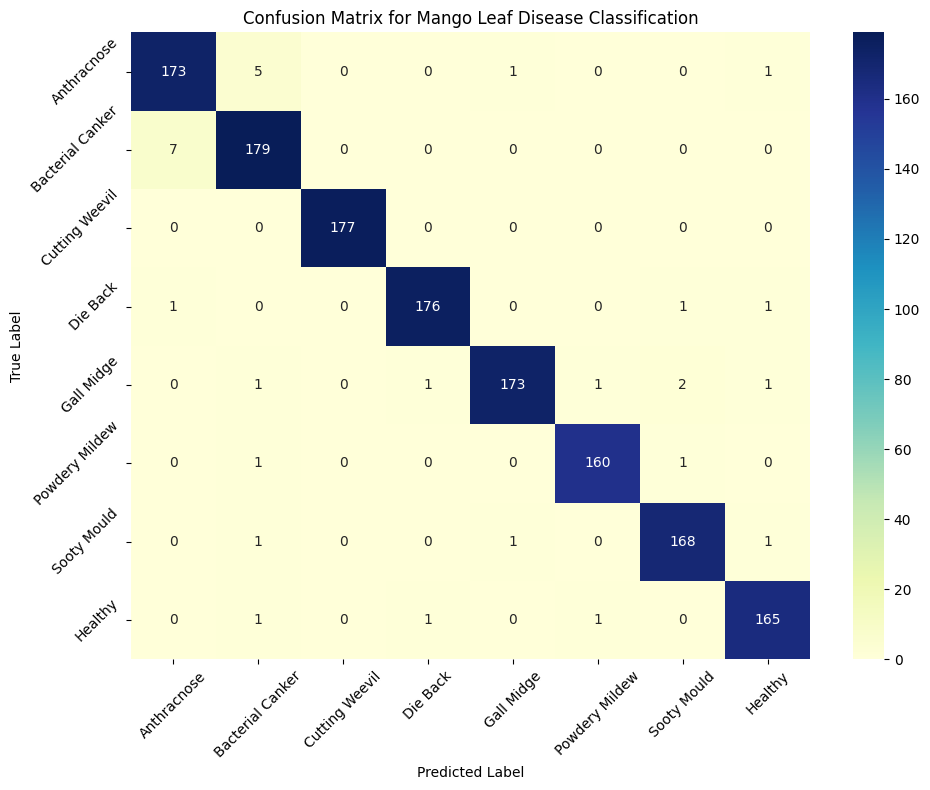

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = list(classes.keys())

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Mango Leaf Disease Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# New section

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7334 - loss: 0.7534 - val_accuracy: 0.9387 - val_loss: 0.1961
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9651 - loss: 0.1196 - val_accuracy: 0.9501 - val_loss: 0.1311
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9868 - loss: 0.0575 - val_accuracy: 0.9643 - val_loss: 0.1081
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9932 - loss: 0.0310 - val_accuracy: 0.9800 - val_loss: 0.0821
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9975 - loss: 0.0185 - val_accuracy: 0.9750 - val_loss: 0.0939
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9970 - loss: 0.0177 - val_accuracy: 0.9729 - val_loss: 0.0824
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9969 - loss: 0.0140 - val_accuracy: 0.9672 - val_loss: 0.1113
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0124 - val_accuracy: 0.9715 - val

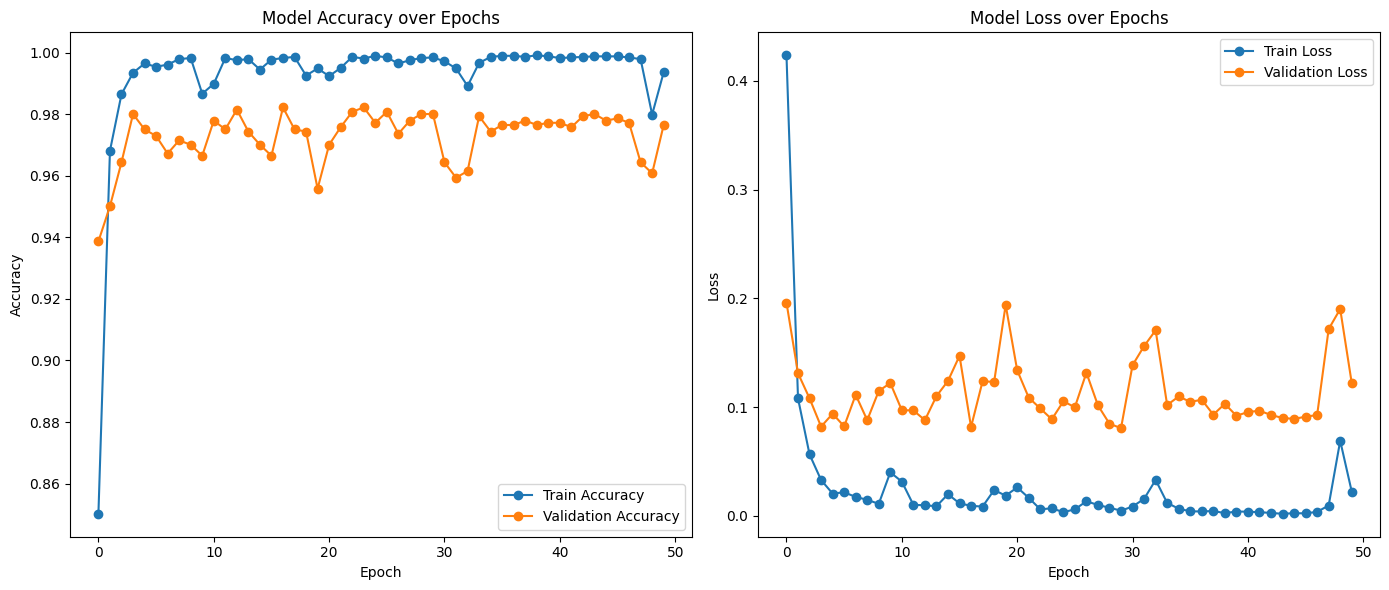

In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import History

# Use extracted features and labels
num_classes = len(classes)

# One-hot encode labels
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)

# Define a simple model on top of extracted features
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_features.shape[1],)),
    Dense(num_classes, activation='softmax')
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model and track history
history = nn_model.fit(X_train_features, y_train_encoded,
                       validation_data=(X_test_features, y_test_encoded),
                       epochs=50, batch_size=32, verbose=1)

# Plot accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Feature vector shape: (1280,)
First 10 feature values: [0.         2.2765255  0.         0.         0.         0.13560724
 0.49348068 1.9112678  0.         0.        ]


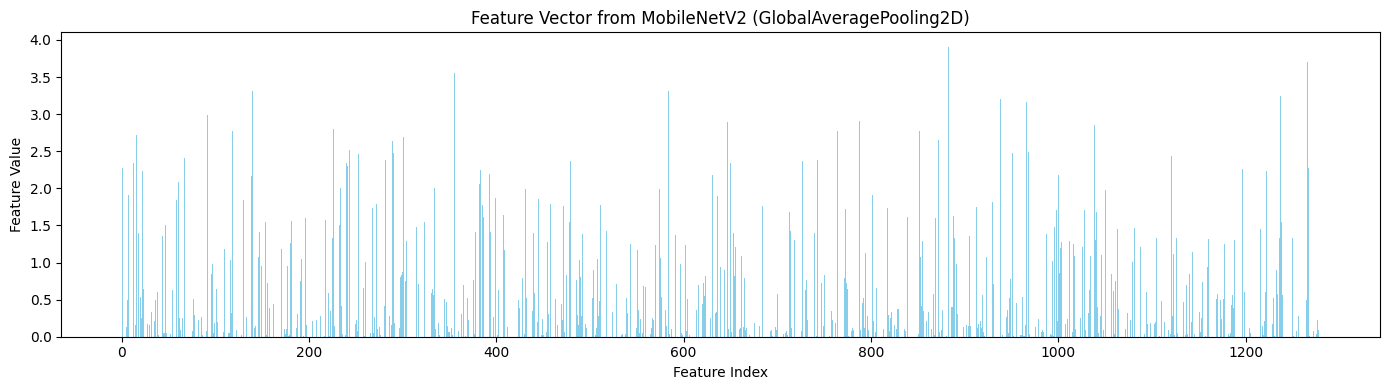

In [22]:
import matplotlib.pyplot as plt

def visualize_feature_vector(image_path, feature_extractor_model, img_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found or cannot be read at {image_path}.")

    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img_expanded = np.expand_dims(img, axis=0)

    features = feature_extractor_model.predict(img_expanded)[0]  # 1D array

    print("Feature vector shape:", features.shape)
    print("First 10 feature values:", features[:10])

    # Plotting the feature vector as a bar chart
    plt.figure(figsize=(14, 4))
    plt.bar(range(len(features)), features, color='skyblue')
    plt.title("Feature Vector from MobileNetV2 (GlobalAveragePooling2D)")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_feature_vector(
    "/content/drive/MyDrive/MangoLeaf_dataset/test/Cutting Weevil/20211011_160904(0) (Custom) (Custom).jpg",
    feature_extractor,
    img_size=IMG_SIZE
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Feature map shape: (4, 4, 1280)


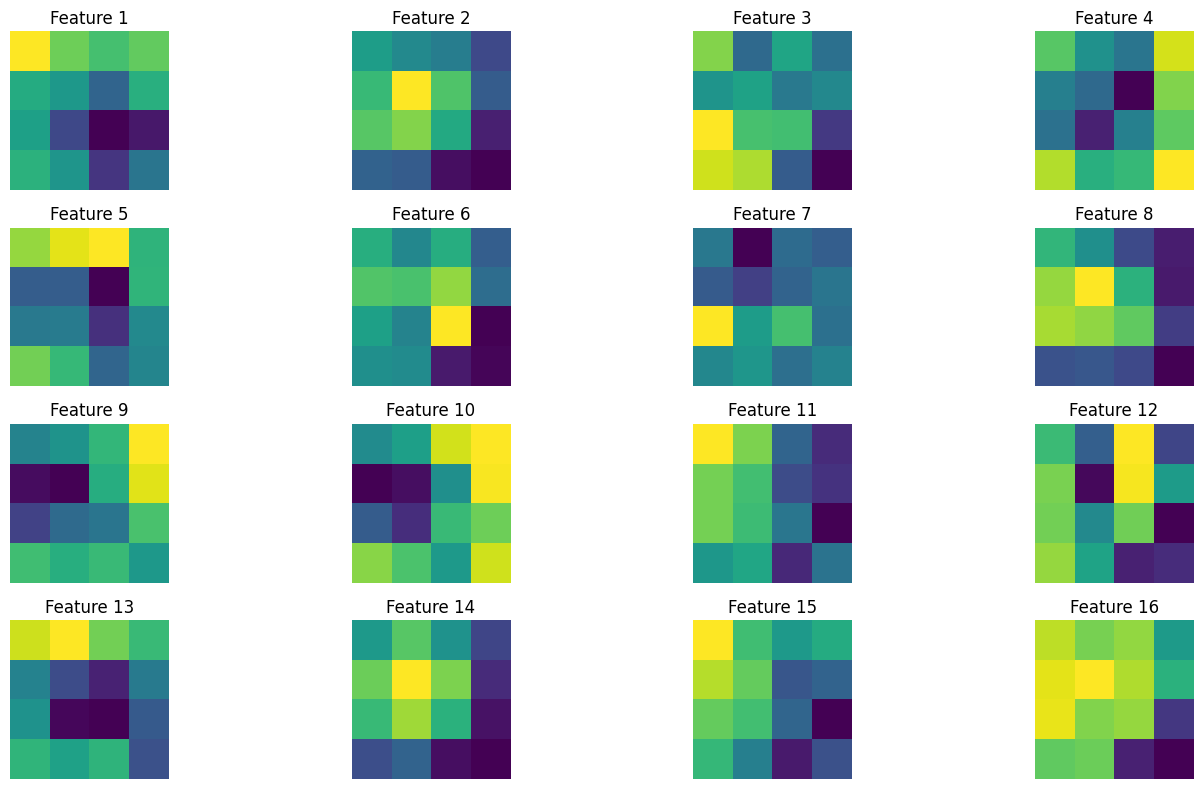

In [23]:
def extract_and_show_feature_maps(image_path, feature_extractor_model, img_size=(128, 128), max_maps=16):
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")

    img = cv2.resize(img, img_size)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_normalized = img_rgb / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)

    # Create a model that outputs feature maps before GlobalAveragePooling
    intermediate_layer_model = Model(inputs=feature_extractor_model.input, outputs=feature_extractor_model.layers[-2].output)
    feature_maps = intermediate_layer_model.predict(img_batch)[0]

    print(f"Feature map shape: {feature_maps.shape}")  # (H, W, Channels)

    # Select a subset of feature maps to display
    num_maps = min(max_maps, feature_maps.shape[-1])
    plt.figure(figsize=(15, 8))
    for i in range(num_maps):
        plt.subplot(4, 4, i+1)
        plt.imshow(feature_maps[:, :, i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Feature {i+1}')
    plt.tight_layout()
    plt.show()

# Example usage:
extract_and_show_feature_maps(
    "/content/drive/MyDrive/MangoLeaf_dataset/test/Cutting Weevil/20211011_160904(0) (Custom) (Custom).jpg",
    base_model,  # Use base_model (MobileNetV2 without pooling)
    img_size=IMG_SIZE,
    max_maps=16  # Show 16 feature maps
)



Shape of logistic input (features): (5607, 1280)
Shape of labels: (5607,)

Feature vector for sample 0 (used by Logistic Regression):

[0.         0.21559948 0.         ... 0.06121299 0.46869063 0.        ]


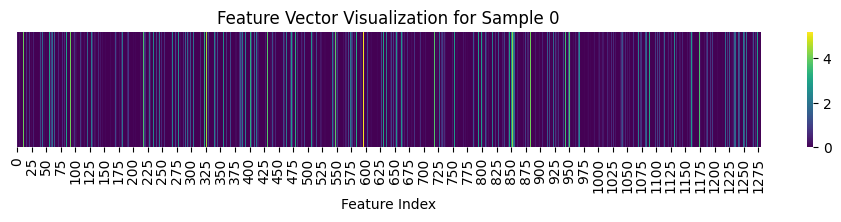

Corresponding label: 2
Corresponding class: Cutting Weevil


In [24]:
import pandas as pd
import seaborn as sns

def show_logistic_input_data(features, labels, sample_index=0):
    print("Shape of logistic input (features):", features.shape)
    print("Shape of labels:", labels.shape)

    # Display one sample vector
    print(f"\nFeature vector for sample {sample_index} (used by Logistic Regression):\n")
    print(features[sample_index])

    # Optional: show as a heatmap (easier to visualize long 1D vector)
    plt.figure(figsize=(12, 1.5))
    sns.heatmap([features[sample_index]], cmap="viridis", cbar=True)
    plt.title(f"Feature Vector Visualization for Sample {sample_index}")
    plt.xlabel("Feature Index")
    plt.yticks([])
    plt.show()

    # Show corresponding label
    class_names_reverse = {v: k for k, v in classes.items()}
    print("Corresponding label:", labels[sample_index])
    print("Corresponding class:", class_names_reverse[labels[sample_index]])

# Example usage:
show_logistic_input_data(X_train_features, y_train, sample_index=0)
